<a href="https://colab.research.google.com/github/sayakpaul/Training-BatchNorm-and-Only-BatchNorm/blob/master/Visualization_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
- https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip install wandb -q
import wandb
wandb.login()

In [0]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import resnet_cifar10
import numpy as np
import cv2
import os

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [0]:
LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog",
	"frog", "horse", "ship", "truck"]

In [6]:
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_test = x_test/255.

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def get_training_model(optimizer="sgd"):
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [0]:
def get_sample_test_image():
    idx = np.random.choice(x_test.shape[0], 1)
    plt.imshow(x_test[idx].squeeze(0))
    plt.title(LABELS[int(y_test[idx])])
    plt.show()
    return idx

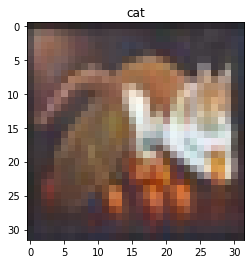

In [9]:
# Test
sample_image_id = get_sample_test_image()
sample_image = x_test[sample_image_id]

In [0]:
def del_weights():
    if os.path.exists("model-best.h5"):
        !rm -rf model-best.h5
        print("Previous weights deleted!")

del_weights()

In [0]:
# Load the weights
resnet_adam = get_training_model("adam")
resnet_adam_weights = wandb.restore("model-best.h5", run_path="sayakpaul/training-bn-only/resnet-ramups-adam")
resnet_adam.load_weights(resnet_adam_weights.name)

In [13]:
# Inspect the output shapes of the conv layers
conv_ids = []
for i in range(len(resnet_adam.layers)):
	layer = resnet_adam.layers[i]
	# check for convolutional layer
	if "conv" not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)
	conv_ids.append(i)

1 conv2d_166 (None, 32, 32, 16)
4 conv2d_168 (None, 32, 32, 16)
7 conv2d_169 (None, 32, 32, 16)
10 conv2d_170 (None, 32, 32, 64)
11 conv2d_167 (None, 32, 32, 64)
15 conv2d_171 (None, 32, 32, 16)
18 conv2d_172 (None, 32, 32, 16)
21 conv2d_173 (None, 32, 32, 64)
25 conv2d_175 (None, 32, 32, 64)
28 conv2d_176 (None, 16, 16, 64)
31 conv2d_177 (None, 16, 16, 128)
32 conv2d_174 (None, 16, 16, 128)
36 conv2d_178 (None, 16, 16, 64)
39 conv2d_179 (None, 16, 16, 64)
42 conv2d_180 (None, 16, 16, 128)
46 conv2d_182 (None, 16, 16, 128)
49 conv2d_183 (None, 8, 8, 128)
52 conv2d_184 (None, 8, 8, 256)
53 conv2d_181 (None, 8, 8, 256)
57 conv2d_185 (None, 8, 8, 128)
60 conv2d_186 (None, 8, 8, 128)
63 conv2d_187 (None, 8, 8, 256)


In [14]:
# conv layer at 10th index
model = Model(inputs=resnet_adam.inputs, outputs=resnet_adam.layers[10].output)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_166 (Conv2D)          (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_164 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
re_lu_164 (ReLU)             (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_168 (Conv2D)          (None, 32, 32, 16)        272       
_________________________________________________________________
batch_normalization_165 (Bat (None, 32, 32, 16)        64        
_________________________________________________________________
re_lu_165 (ReLU)             (None, 32, 32, 16)        0   

In [15]:
# Extending to multiple images
few_images = []
idx = np.random.choice(x_test.shape[0], 8)
for single_image in idx:
    few_images.append(x_test[single_image])
few_images = np.array(few_images)

few_images.shape

(8, 32, 32, 3)

In [16]:
# Extract the feature maps
feature_maps_multi = model.predict(few_images)
feature_maps_multi.shape

(8, 32, 32, 64)

In [17]:
wandb.init(project="training-bn-only", id="visualization-resnet")

W&B Run: https://app.wandb.ai/sayakpaul/training-bn-only/runs/visualization-resnet

In [0]:
# Visualize
square = 8
ix = 1
fig = plt.figure(figsize=(16, 16))
for (i, feature_map) in zip(range(square), feature_maps_multi):
    for j in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            plt.imshow(few_images[i].squeeze())
        else:
            if np.ndim(feature_map) != 4:
                feature_map = np.expand_dims(feature_map, 0)
            plt.imshow(feature_map[0, :, :, ix-1], cmap="binary")
        ix += 1

wandb.log({"10th_conv_filter": fig})
plt.close()

**Note**: One may need to delete the previous model weights first. The most preferred way here is to manually download the model weights from [this run page](https://app.wandb.ai/sayakpaul/training-bn-only/runs/bn-only-adam/files?workspace=user-sayakpaul) and upload the file to Colab. 

In [0]:
# Load the weights of BN only ResNet
# del_weights()
resnet_bn_adam = get_training_model("adam")
# resnet_adam_bn_weights = wandb.restore("model-best.h5", run_path="sayakpaul/training-bn-only/bn-only-adam")
resnet_bn_adam.load_weights("model-best.h5")

In [29]:
wandb.init(project="training-bn-only", id="visualization-bn-only")

W&B Run: https://app.wandb.ai/sayakpaul/training-bn-only/runs/visualization-bn-only

In [0]:
# conv layer at 10th index
model = Model(inputs=resnet_bn_adam.inputs, outputs=resnet_bn_adam.layers[10].output)

# Extract the feature maps
feature_maps_multi = model.predict(few_images)

# Visualize
square = 8
ix = 1
fig = plt.figure(figsize=(16, 16))
for (i, feature_map) in zip(range(square), feature_maps_multi):
    for j in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            plt.imshow(few_images[i].squeeze())
        else:
            if np.ndim(feature_map) != 4:
                feature_map = np.expand_dims(feature_map, 0)
            plt.imshow(feature_map[0, :, :, ix-1], cmap="binary")
        ix += 1

wandb.log({"10th_conv_filter": fig})
plt.close()